Project created using RAVDESS Emotional speech audio dataset:
https://zenodo.org/records/1188976


In [227]:
import os
import numpy as np
from scipy.io.wavfile import read as read_wav
from scipy.signal import spectrogram
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.svm import SVC
import optuna
import librosa
import librosa.display
import seaborn as sn
import pandas as pd

In [228]:
def CreateSampleData(emotion_name,file_list, sample_list):
    '''Function which return data of single recording of desired emotion type coming from one actor and appends it to certain list'''
    if emotion_name=='neutral':
        emotion_num='01'
    elif emotion_name=='calm':
        emotion_num='02'
    elif emotion_name=='happy':
        emotion_num='03'
    elif emotion_name=='sad':
        emotion_num='04'
    elif emotion_name=='angry':
        emotion_num='05'
    elif emotion_name=='fearful':
        emotion_num='06'
    elif emotion_name=='disgust':
        emotion_num='07'
    elif emotion_name=='surprised':
        emotion_num='08'

    for file in file_list:
        if file[-18:-16]==emotion_num and file[-6:-4]=='01':
            samplerate,data=read_wav(file)
            break
    sample_list.append(data)
    return samplerate, data


In [229]:
emotion_names=['neutral','calm','happy','sad','angry','fearful','disgust','surprised']

Name of the file is 7 part numerical identifier, from which the 3rd part defines emotion of the recording

In [230]:
current_dir = Path.cwd()
path = current_dir / 'Recordings/'

all_files=[]
for i in range(1,25):   
    path_current_actor=path/f'Actor_{i}'
    for directory, subdirs, files in os.walk(path_current_actor):
        all_files.extend([f"{directory}/{file}" for file in files])
print(len(all_files))

1440


In [231]:
sample_data=[]

In [232]:
fs,neutral_data=CreateSampleData('neutral',all_files,sample_data)
fs,calm_data=CreateSampleData('calm',all_files,sample_data)
fs,happy_data=CreateSampleData('happy',all_files,sample_data)
fs,sad_data=CreateSampleData('sad',all_files,sample_data)
fs,angry_data=CreateSampleData('angry',all_files,sample_data)
fs,fearful_data=CreateSampleData('fearful',all_files,sample_data)
fs,disgust_data=CreateSampleData('disgust',all_files,sample_data)
fs,surprised_data=CreateSampleData('surprised',all_files,sample_data)

/var/folders/qb/279v3kbj47ddq3xj8qvmb51w0000gn/T/ipykernel_7599/1038933194.py:22: WavFileWarning: Chunk (non-data) not understood, skipping it.
  samplerate,data=read_wav(file)


In [233]:
print(fs)

48000


Shortening each file so that all the lengths are the same

In [234]:
sig_len=[len(data) for data in sample_data]
length=min(sig_len)
cropped_samples=[data[:length] for data in sample_data]

Signals of each emotion coming form one actor in time domain

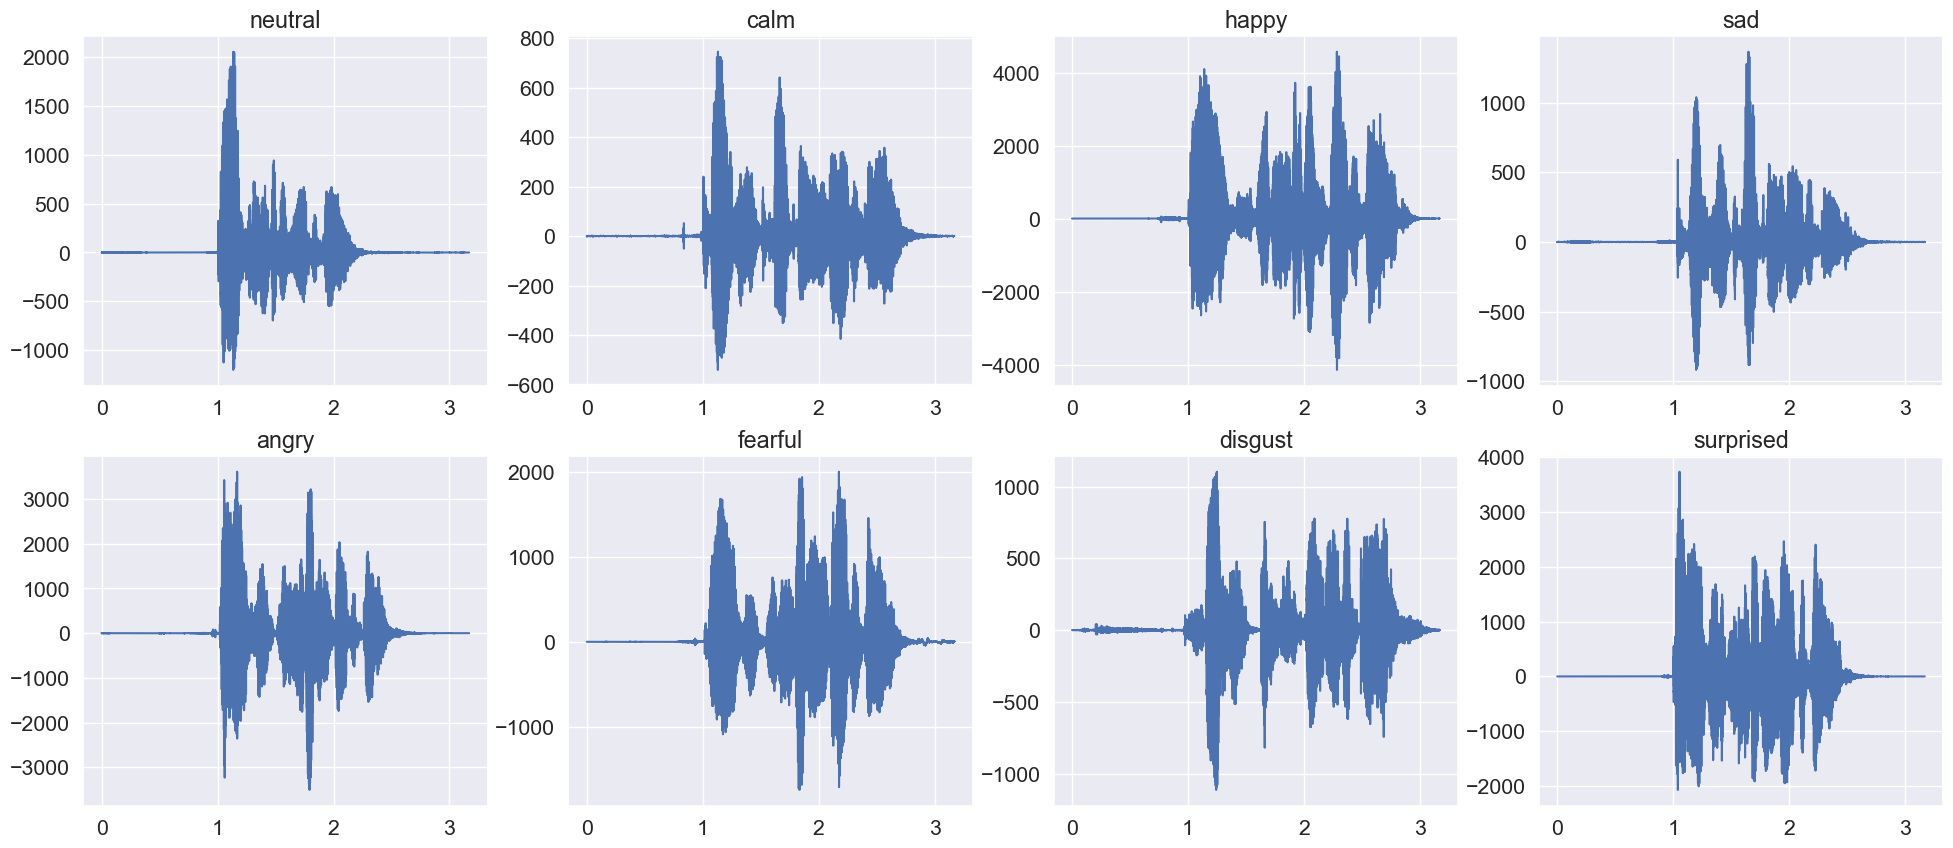

In [235]:
plt.figure(figsize=(24,10))
i=1
time=np.arange(0,length/fs,1/fs)
emotion_names=['neutral','calm','happy','sad','angry','fearful','disgust','surprised']
for sample in cropped_samples:
   plt.subplot(2,4,i)
   plt.plot(time,sample)
   plt.title(f'{emotion_names[i-1]}')
   i+=1

In [236]:
labels=[]
for file in all_files:
    if file[-18:-16]=='01':
        labels.append('neutral')
    elif file[-18:-16]=='02':
        labels.append('calm')
    elif file[-18:-16]=='03':
        labels.append('happy')
    elif file[-18:-16]=='04':
        labels.append('sad')
    elif file[-18:-16]=='05':
        labels.append('angry')
    elif file[-18:-16]=='06':
        labels.append('fearful')
    elif file[-18:-16]=='07':
        labels.append('disgust')
    elif file[-18:-16]=='08':
        labels.append('surprised')
print(len(labels))


1440


Counting elements of each class with histogram

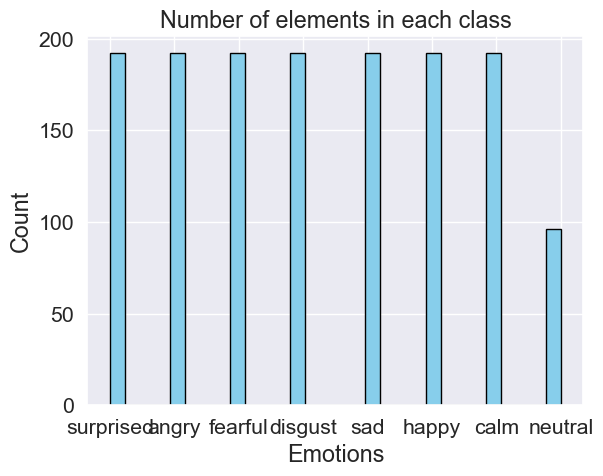

In [237]:
plt.figure(figsize=(12,6))
plt.hist(labels, bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Emotions')
plt.ylabel('Count')
plt.title('Number of elements in each class')
plt.show()

Spectrograms of each emotion coming from one actor

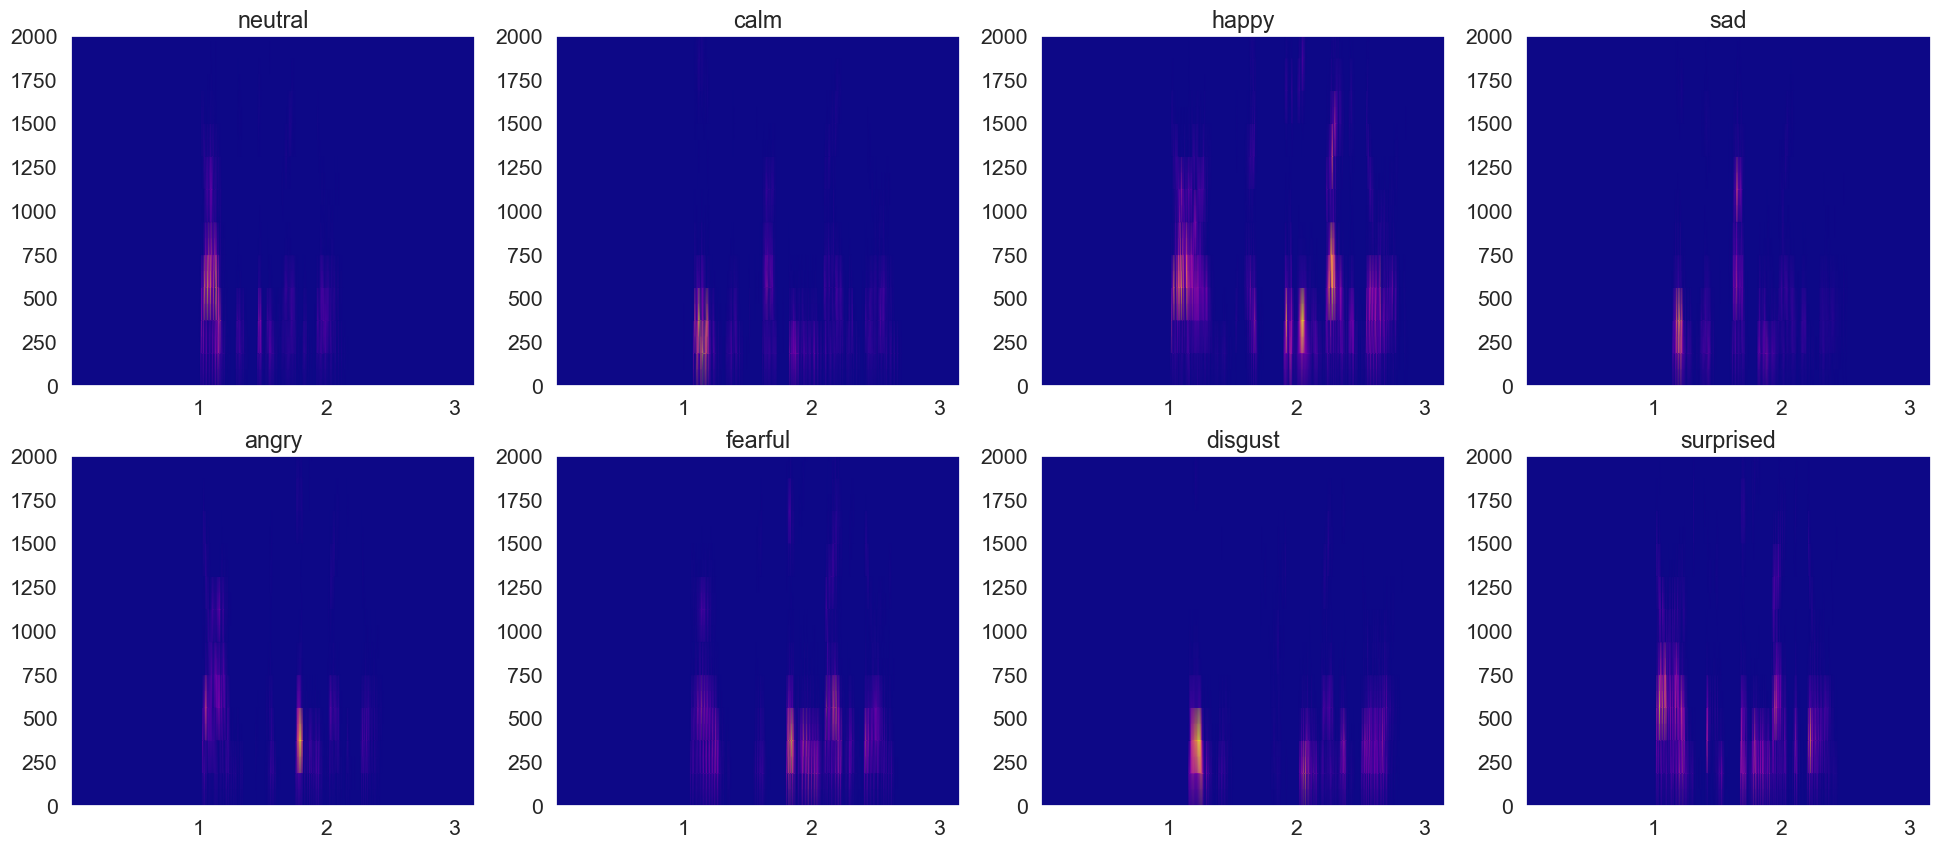

In [238]:
plt.figure(figsize=(24,10))
i=1
for sample in cropped_samples:
    plt.subplot(2,4,i)
    f, t, Sxx = spectrogram(sample, fs)
    plt.pcolormesh(t, f, Sxx, shading='gouraud', cmap='plasma')
    plt.ylim(0,2000)
    plt.title(f'{emotion_names[i-1]}')
    i+=1

Preparing mfcc for classification

In [239]:
mfccs = []
sig_len = []
for file in all_files:
    x, fs = librosa.load(file)
    mfcc_13_coeffs = librosa.feature.mfcc(y=x, sr=fs, n_mfcc=13)
    mfccs.append(mfcc_13_coeffs)
    sig_len.append(np.shape(mfcc_13_coeffs)[1])
prep_mfccs = []
for item in mfccs:
    item = item[:, :np.min(sig_len)]
    prep_mfccs.append(item)
mfccs = np.asarray(prep_mfccs)

[Text(0.5, 1.0, 'MFCC')]

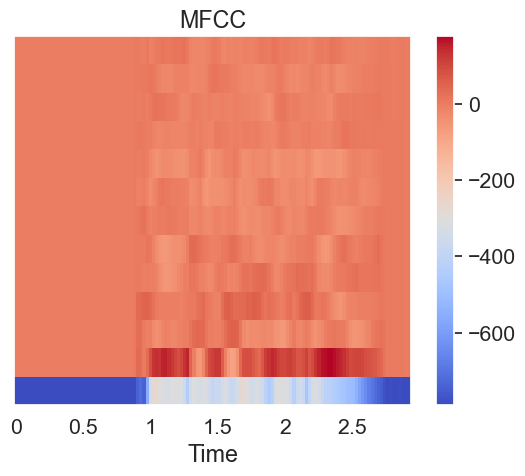

In [240]:
fig, ax = plt.subplots()
img = librosa.display.specshow(mfccs[0], x_axis='time', ax=ax)
fig.colorbar(img, ax=ax) 
ax.set(title='MFCC')

KNN Model

In [241]:
X_train, X_test, y_train, y_test = train_test_split(mfccs, labels, test_size=0.2, random_state=42, stratify=labels)
X_train = np.array(X_train).reshape(np.shape(X_train)[0],-1)
X_test = X_test.reshape(np.shape(X_test)[0],-1)

In [242]:
clf = KNeighborsClassifier(n_neighbors=7) 
clf.fit(X_train, y_train)
preds = clf.predict(X_test)

In [243]:
matrix=confusion_matrix(y_test, preds)

<Axes: >

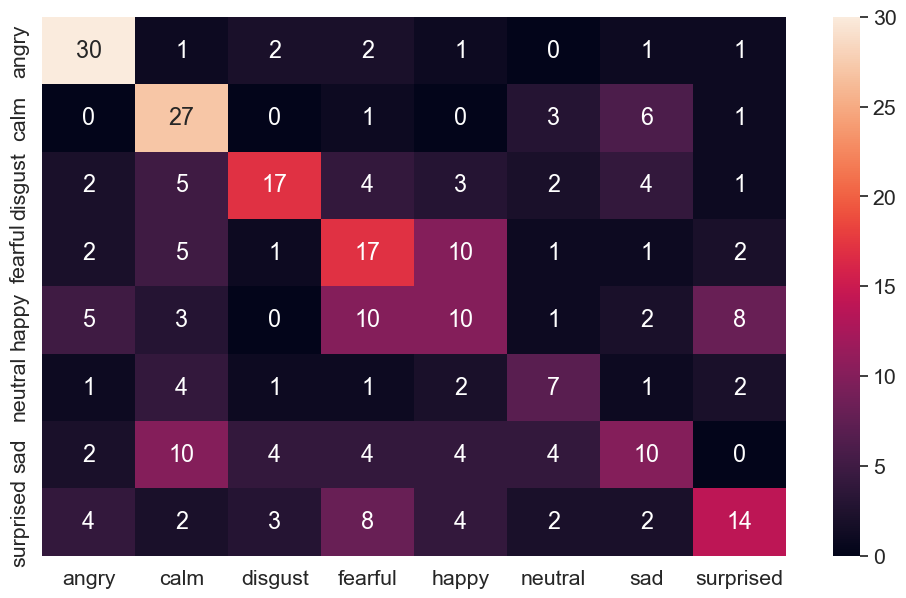

In [244]:
df_cm = pd.DataFrame(matrix, index = sorted(emotion_names),
                  columns = sorted(emotion_names))
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)

In [245]:
f1=f1_score(y_pred=preds,y_true=y_test,average='weighted')
acc=accuracy_score(y_pred=preds,y_true=y_test)
print(f"Metrics for current model:\n"
      f"f1={f1}\n"
      f"accuracy={acc}")

Metrics for current model:
f1=0.44789512124603853
accuracy=0.4583333333333333


SVM model

In [246]:
SVM = SVC(kernel='poly',degree=8,coef0=1,C=6)
SVM.fit(X_train, y_train)
preds = SVM.predict(X_test)

In [247]:
matrix=confusion_matrix(y_test, preds)

<Axes: >

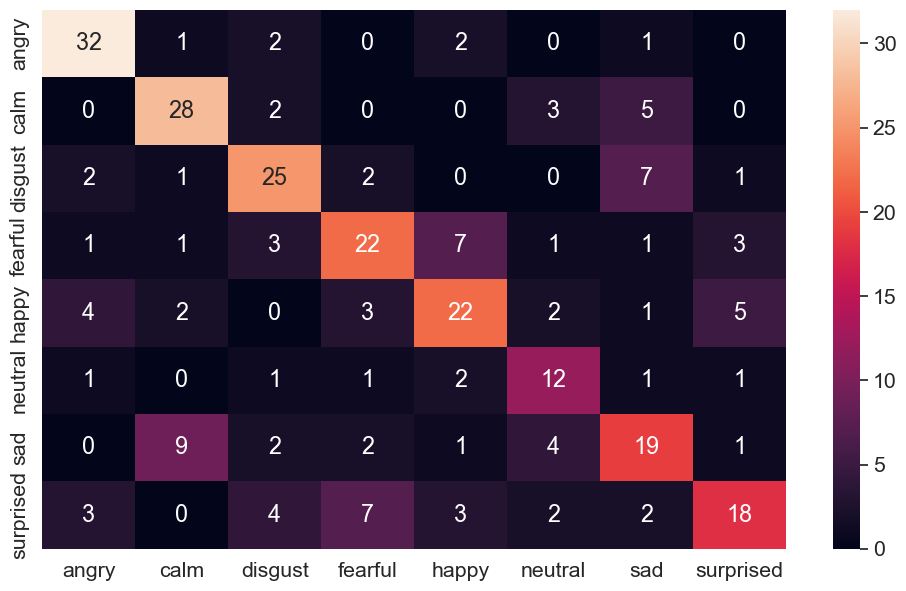

In [248]:
df_cm = pd.DataFrame(matrix, index = sorted(emotion_names),
                  columns = sorted(emotion_names))
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)

In [249]:
f1=f1_score(y_pred=preds,y_true=y_test,average='weighted')
acc=accuracy_score(y_pred=preds,y_true=y_test)
print(f"Metrics for current model:\n"
      f"f1={f1}\n"
      f"accuracy={acc}")

Metrics for current model:
f1=0.6144547017008504
accuracy=0.6180555555555556
